In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

from src.green_net import GreenNet2D
from src.toep_gmg import Toep_GMG2D
from src.model import MLP
from src.utils import rl2_error

In [2]:
def DiskInvdist(pts):
    x1 = pts[...,0]
    y1 = pts[...,1]
    x2 = pts[...,2]
    y2 = pts[...,3]

    mask = ((x1**2+y1**2) < 1) & ((x2**2+y2**2) < 1)

    k = ((x1 - x2)**2 + (y1-y2)**2) ** (-0.5)
    k = torch.nan_to_num(k, posinf=70) * mask

    return k

In [3]:
def ToepDiskInvdist(pts):
    x = pts[...,0]
    y = pts[...,1]
    mask = (x**2+y**2)**0.5 < 2
    k = (x**2 + y**2) ** (-0.5)
    k = torch.nan_to_num(k, posinf=70) * mask

    return k

In [4]:
def ffunc_2D(pts):
    x = pts[:,0]
    y = pts[:,1]
    u = 1 - (x**2+y**2)
    mask = (x**2+y**2)**0.5 < 1
    u = u * mask
    return u

In [5]:
n = 7
device = torch.device('cpu')
model = GreenNet2D(n, kernel=DiskInvdist, device=device, sub_num=5)

In [6]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)
model.eval_K()
nh = model.grid.nh
K_full = model.K_hh.reshape(nh,nh,nh,nh)

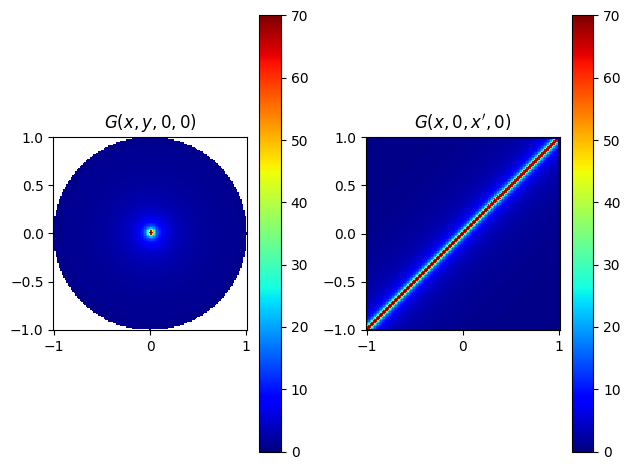

In [7]:
xy = model.grid.x_h.reshape(nh,nh,2)
mask = (xy[...,0]**2 + xy[...,1]**2) > 1
G_xy00 = K_full[:,:,65,65]
G_xy00[mask] = torch.nan
G_x0y0 = K_full[:,65,:,65]
plt.subplot(121)
plt.pcolor(xy[...,0], xy[...,1], G_xy00, cmap='jet')
plt.title('$G(x,y,0,0)$')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.pcolor(xy[...,0], xy[...,1], G_x0y0, cmap='jet')
plt.title('$G(x,0,x\',0)$')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()

Full Kernel Integral

In [8]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)
U_full = model.full_kint(F)

# Toep Green Net

In [9]:
# toep green net
m = 0
k = 0
toep_gmg = Toep_GMG2D(n, m, k, ToepDiskInvdist, device)

# coarest pts :  66049
# correction :  0
ratio 66049/66049 = 100.00% 



In [10]:
toep_gmg.eval_ml_K()
toep_gmg.assemble_K()

In [11]:
toep_K_h = toep_gmg.K_h.clone()
x_h = toep_gmg.ml_grids[-1].x_h

toeplitz kernel visualization

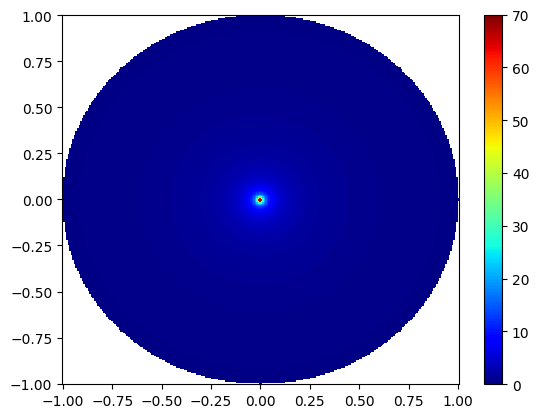

In [12]:
nh = toep_gmg.ml_grids[-1].nh * 2 - 1
mask = (x_h[...,0]**2 + x_h[...,1]**2).reshape(nh,nh)>1
toep_K_h[mask] = torch.nan
plt.pcolor(x_h[:,0].reshape(nh,nh), x_h[:,1].reshape(nh,nh), toep_K_h, cmap='jet')
plt.colorbar()

# Toep Green MG

influence of level of coarse : `k`

In [13]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> b n', b=64)
model = GreenNet2D(n, kernel=DiskInvdist, device=device, sub_num=5)
model.eval_K()
U_full = model.full_kint(F)

In [14]:
m = 0

for k in range(0, 4):
    toep_gmg = Toep_GMG2D(n, m, k, ToepDiskInvdist, device)
    toep_gmg.eval_ml_K()
    toep_gmg.assemble_K()
    U_toep = toep_gmg.fft_kint(F)
    rl2 = rl2_error(U_toep, U_full)
    print('k {:d} - {:.4f}'.format(k, rl2))

# coarest pts :  66049
# correction :  0
ratio 66049/66049 = 100.00% 

k 0 - 0.0000
# coarest pts :  16641
# correction :  1
ratio 16642/66049 = 25.20% 

k 1 - 0.0021
# coarest pts :  4225
# correction :  2
ratio 4227/66049 = 6.40% 

k 2 - 0.0138
# coarest pts :  1089
# correction :  3
ratio 1092/66049 = 1.65% 

k 3 - 0.1252


influence of correction range : `c`

In [15]:
k = 3

for m in [0, 1, 3, 5, 7, 15]:
    toep_gmg = Toep_GMG2D(n, m, k, ToepDiskInvdist, device)
    toep_gmg.eval_ml_K()
    toep_gmg.assemble_K()
    U_toep = toep_gmg.fft_kint(F)
    rl2 = rl2_error(U_toep, U_full)
    print('k {:d} - m {:d} - {:.4e}\n'.format(k, m, rl2))

# coarest pts :  1089
# correction :  3
ratio 1092/66049 = 1.65% 

k 3 - m 0 - 1.2519e-01

# coarest pts :  1089
# correction :  24
ratio 1113/66049 = 1.69% 

k 3 - m 1 - 9.5456e-03

# coarest pts :  1089
# correction :  120
ratio 1209/66049 = 1.83% 

k 3 - m 3 - 4.3494e-03

# coarest pts :  1089
# correction :  288
ratio 1377/66049 = 2.08% 

k 3 - m 5 - 2.4386e-03

# coarest pts :  1089
# correction :  528
ratio 1617/66049 = 2.45% 

k 3 - m 7 - 1.5034e-03

# coarest pts :  1089
# correction :  2208
ratio 3297/66049 = 4.99% 

k 3 - m 15 - 3.4037e-04

